# Ay119: NoSQL databases: MongoDB

In this exercise, we will work with one of the most popular (document-based) NoSQL databases - [`MongoDB`](https://mongodb.com). 
Concretely, we will:

- Deploy a `MongoDB` database using `docker` 
    - Set up `docker`
- Fetch some public transient alerts from the [Zwicky Transient Facility](https://ztf.caltech.edu), ingest them into the database, and create indices in the database for faster queries
- Query the database using python
    - Inspect the contents of an alert packet
    - Construct and plot a light curve
    - Plot the cutout images from an alert packet

Prerequisites:

- `Docker`
- `python>=3.7`
- python libraries: `pymongo` `requests` `matplotlib` `numpy` `pandas` `astropy` `tqdm`

## Set up

For a quick introduction into NoSQL databases, please read [these slides](https://github.com/dmitryduev/ay119/raw/master/databases/Ay119_NoSQL_databases.pdf).

### Docker

With the help from `docker`, setting up `MongoDB` on the local machine will take only a few simple steps.

`Docker` uses OS-level virtualization to deliver software in packages called containers. Containers are isolated from one another and bundle their own software, libraries and configuration files; they can communicate with each other through well-defined channels. All containers are run by a single operating system kernel and therefore use fewer resources than virtual machines. [\[Wikipedia\]](https://en.wikipedia.org/wiki/Docker_(software))

Follow the [instructions from docker.com](https://docs.docker.com/engine/install/) to install and set up `docker` on your platform.

### MongoDB

Create a persistent `docker` volume (so that your data are not wiped out when you remove the container):

In [1]:
!docker volume create mongo-volume

mongo-volume


The following command will pull the latest `MongoDB` image from the [official image registry](https://hub.docker.com/_/mongo) and use that image to spin up a container running the DBMS. It will also set up the root credentials and use the newly created `mongo-volume` persistent volume to store the data.

In [2]:
!docker run -d --restart always --name mongo -p 27017:27017 \
    -v mongo-volume:/data/db \
    -e MONGO_INITDB_ROOT_USERNAME=mongoadmin \
    -e MONGO_INITDB_ROOT_PASSWORD=mongoadminsecret \
    mongo:latest

c216f092bfb44125bb4be62928661d384ceb2ff9003da06291376ffcce167853


Verify that the container is up and running:

In [3]:
!docker ps -a

CONTAINER ID   IMAGE          COMMAND                  CREATED         STATUS                       PORTS                      NAMES
c216f092bfb4   mongo:latest   "docker-entrypoint.s…"   8 seconds ago   Up Less than a second        0.0.0.0:27017->27017/tcp   mongo
baf6969a448a   9f4d3c8571a7   "/bin/bash"              2 weeks ago     Exited (1) 2 weeks ago                                  inspiring_lamport
523cc09a0ee8   b9a6d58e6f99   "/bin/bash"              2 weeks ago     Exited (1) 2 weeks ago                                  peaceful_buck
29ada423740b   0e848ea9c204   "/bin/bash"              2 weeks ago     Exited (1) 2 weeks ago                                  upbeat_leavitt
b999bf6f6775   e7d1ef30040c   "/bin/bash"              13 months ago   Exited (130) 13 months ago                              stoic_jennings
80c48a5184cc   dc9fa901212c   "/bin/bash"              13 months ago   Created                                                 intelligent_volhard
cb244bb66448   00

The database is up and running and we can proceed working with it.

#### Clean up

Once you are done with this exercise, to stop and remove the container, run:

In [4]:
# !docker stop mongo && docker rm -f mongo

To remove the persistent volume, run:

In [5]:
# !docker volume rm mongo-volume

### python libraries:

Make sure to install the following python libraries:

In [6]:
%%capture
!pip install pymongo requests matplotlib numpy pandas astropy tqdm

## Why use MongoDB in astronomy?

[`MongoDB`](https://www.mongodb.com/what-is-mongodb), the [most popular and feature-rich document-based NoSQL database to date](https://db-engines.com/en/ranking), naturally fits a number of use cases in astronomy, especially in modern time-domain astronomy.

- Uses <a href="https://www.mongodb.com/json-and-bson" target="_blank">BSON</a> (serialized binary python-dictionary-like structures) documents to store the data in collections (a rough analog of a table in the RDBMS world). 
    - Natural to store alerts from sky surves such as ZTF or the upcoming [LSST](https://www.lsst.org/). For example, the widely used [AVRO](https://avro.apache.org/) format directly translates into BSON. 
    - Astronomical object light curves - 1 read per source to extract all data points for a source as opposed to multiple joins if RDBMS were used (one row per data point).
- Giant [B-tree](https://en.wikipedia.org/wiki/B-tree): O(log(N)) guaranteed for search, insert, and delete operations, where N is the number of documents in a collection
    - blazing fast with (multiple) clever (compound) indexes and covered queries
- No schema by default but can be enforced if need be
    - No downtime when the incoming data schema changes, e.g. the alert packet schema evolves over time
- Built-in [GeoJSON support with 2D indices on the sphere](https://docs.mongodb.com/manual/reference/geojson/)
    - Positional queries (e.g. cone-searches) are supported out of the box with excellent performance
- [MongoDB Query Language (MQL)](https://docs.mongodb.com/manual/tutorial/query-documents/): cone and general searches, aggregation pipelines
    - Supports LEFT-OUTER-JOIN-like operations
- Horizontal scale-out
    - Sharding supported out-of-the box
- ACID-compliant transactions:
    - As of version `4.2` supports transactions and is ACID-compliant even across sharded clusters
    
For a very quick intro into MongoDB, watch [MongoDB in 5 Minutes with Eliot Horowitz](https://www.youtube.com/watch?v=EE8ZTQxa0AM).

## Public transient alerts from the Zwicky Transient Facility

The [Zwicky Transient Facility (ZTF)](https://ztf.caltech.edu) is a state-of-the-art robotic optical sky survey currently in operation at the Palomar Observatory in Southern California. ZTF performs accurate measurements of billions of astronomical objects and registers millions of transient "events" (such as, for example, supernova explosions, brightness changes in variable stars, or asteroids) in the dynamic sky every (clear) night.

Events observed by ZTF may have been triggered from a flux-transient, a reoccurring flux-variable, or a moving object. The metadata and contextual information including the cutouts are put into "alert packets" that are distributed via the ZTF Alert Distribution System (ZADS). On a typical night, the number of detected events ranges from $10^5 - 10^6$.

<table><tr><td><img src='img/fig-ztf.png'></td><td><img src='img/fig-ztf_alerts.png'></td></tr></table>

### Alert sample

In this exercise, we will work with a small set of public ZTF alerts (~300) originating from SNe, AGN, variable stars, asteroids, and bogus events.

The setup we'll be dealing with actually mimics how things work [in production](https://arxiv.org/pdf/1907.11259.pdf), where we store the processed contents of the alerts in two `MongoDB` collections.

<font color='#777'>
Why are the data stored in two collections? To optimize data storage/querying and to remove redundant data, the alert data are dealt with as follows.

Individual alerts minus the prv_candidates block are stored in the `ZTF_alerts` collection. Machine learning models are executed on individual alerts and the results are save to the `classifications` block.

The contents of the `prv_candidates` blocks of individual alerts are stored in the `ZTF_alerts_aux` collection per `objectId`. No filtering is applied, however all duplicate entries originating from different alerts are removed. [In rare cases, there may be both a detection and a non-detection for the same value of `candidate.jd` due to uncertanties in the astrometry.] The data in `prv_candidates` are stored as a set meaning that they are not ordered. Additionally, the information on cross-matched sources from external catalogs (within $5"$) is saved to the `cross_matches` block.
</font>

Let us first fetch the dumps of the two collections.

In [4]:
import pathlib
import subprocess

In [5]:
for f in ('ZTF_alerts.dump', 'ZTF_alerts_aux.dump'):
    if not pathlib.Path(f).exists():
        print(f'Fetching {f}')
        subprocess.run(['wget', f'https://storage.googleapis.com/ztf-fritz/{f}'])

Fetching ZTF_alerts.dump
Fetching ZTF_alerts_aux.dump


Insert the dumps into our running database:

In [6]:
!docker cp ZTF_alerts.dump mongo:/tmp/
!docker cp ZTF_alerts_aux.dump mongo:/tmp/

!docker exec -it mongo \
    mongorestore -u=mongoadmin -p=mongoadminsecret --authenticationDatabase=admin \
    --archive=/tmp/ZTF_alerts.dump --drop

!docker exec -it mongo \
    mongorestore -u=mongoadmin -p=mongoadminsecret --authenticationDatabase=admin \
    --archive=/tmp/ZTF_alerts_aux.dump --drop

!docker exec -it mongo rm /tmp/ZTF_alerts.dump /tmp/ZTF_alerts_aux.dump

2021-01-04T20:52:15.424+0000	preparing collections to restore from
2021-01-04T20:52:15.705+0000	reading metadata for kowalski.ZTF_alerts from archive '/tmp/ZTF_alerts.dump'
2021-01-04T20:52:15.992+0000	restoring kowalski.ZTF_alerts from archive '/tmp/ZTF_alerts.dump'
2021-01-04T20:52:18.222+0000	kowalski.ZTF_alerts  12.8MB
2021-01-04T20:52:18.226+0000	kowalski.ZTF_alerts  12.8MB
2021-01-04T20:52:18.226+0000	restoring indexes for collection kowalski.ZTF_alerts from metadata
2021-01-04T20:52:19.940+0000	finished restoring kowalski.ZTF_alerts (313 documents, 0 failures)
2021-01-04T20:52:19.941+0000	313 document(s) restored successfully. 0 document(s) failed to restore.
2021-01-04T20:52:21.792+0000	preparing collections to restore from
2021-01-04T20:52:21.879+0000	reading metadata for kowalski.ZTF_alerts_aux from archive '/tmp/ZTF_alerts_aux.dump'
2021-01-04T20:52:22.002+0000	restoring kowalski.ZTF_alerts_aux from archive '/tmp/ZTF_alerts_aux.dump'
2021-01-04T20:52:22.159+0000	no indexes t

Import some python libraries and helper functions (see [utils.py](utils.py)):

In [8]:
from IPython import display
import numpy as np
import pymongo
import tqdm
from utils import assemble_lc, make_dataframe, make_triplet, plot_triplet_lc

Create a user for the main database that we will call `kowalski` (after a penguin):

In [9]:
def create_user(username='ztf', password='ztfrulez', host='localhost', port=27017, verbose=True):
    _client = pymongo.MongoClient(username='mongoadmin', password='mongoadminsecret', 
                                  host=host, port=port)

    # _id: db_name.user_name
    user_ids = []
    for _u in _client.admin.system.users.find({}, {'_id': 1}):
        user_ids.append(_u['_id'])

    if verbose:
        print(user_ids)

    db_name = 'kowalski'

    _mongo = _client[db_name]

    if f'{db_name}.{username}' not in user_ids:
        _mongo.command('createUser', username, pwd=password, roles=['readWrite'])
        if verbose:
            print('Successfully initialized db')

    _mongo.client.close()

In [10]:
create_user()

['admin.mongoadmin']
Successfully initialized db


Establish a connection to the database:

In [11]:
def connect_to_db(host='localhost', port=27017, user='ztf', password='ztfrulez'):
    _client = pymongo.MongoClient(host=host, port=port)
    # grab main database:
    _db = _client['kowalski']
    # authenticate
    _db.authenticate(user, password)
    
    return _db

In [12]:
db = connect_to_db()

## Querying the alert database

Let us learn by example and construct and execute several queries to demonstrate some of `MongoDB`'s capabilities. But first let's discuss some performance considerations.

#### Collection methods/operations

`MongoDB` supports a wide range of [collection-level operation](https://api.mongodb.com/python/current/api/pymongo/collection.html). The ones listed below are most useful for querying the data:

- The `find` method is used to query a collection using a filter expression. The users have control over, in particular, the result projection/size restriction and index "hints".

- The `find_one` method is similar to `find`, but returns the first filter expression match and does not allow result projection.

- The `count_documents` method is used to count the number of documents in a collection that match a particular filter expression. 

- The `aggregate` method is used to execute aggregation pipelines on a colection potentially involving complicated computations and/or/involving (left outer) joins with other collections.

#### Performance considerations

- When querying your data, you want to minimize the required I/O operations. Indexes on "fields" (think "columns" in `SQL`/table-speak) provide a fast way to find the location of a "document" (think catalog entry) on disk for further retrieval, or even fetching the field value if no other data is needed (so-called "covered queries"). 
- Indexes may be compound to speed-up multi-field queries / enable multi-field covered queries (see below for more details). 
- Whenever possible, construct your queries to use indexes. A query that cannot use an index will initiate a full collection (catalog) scan, which for large catalogs may be very costly in terms of I/O = time/performance.

Let us create an example index:

In [13]:
db['ZTF_alerts'].create_index([
    ('coordinates.radec_geojson', '2dsphere'), 
    ('objectId', -1),
    ('candid', -1),
])

'coordinates.radec_geojson_2dsphere_objectId_-1_candid_-1'

Now whenever you are querying the alert collection by sky position, it will be very fast to grab the alert's fields `objectId` and `candid` -- the DBMS will not even need to look at the stored documents themselves, just the index.

The database wants to minimize I/O, too, so when you make a query, it will first try to find an index to speed up your query. You can explicitely provide it with a `hint` on what index to try and use (see below).

<div style="color: #721c24;
    background-color: #f8d7da;
    border-color: #f5c6cb;
    padding: .75rem 1.25rem;
    margin-bottom: 1rem;
    border: 1px solid transparent;
    border-radius: .25rem;">
    If the database fails to find such an index, it will have to look at the individual documents on disk.
    <br><br>
    The same applies if you make a typo and query the <tt>ZTF_alerts</tt> catalog for, for example, "objectID" or "candidate.objectId" (both don't exist) instead of "objectId", the database will have to look at <b>all</b> entries in the database.
</div>

#### Compound indexes and prefixes

See a detailed discussion of compound indexes in `MongoDB` [here](https://docs.mongodb.com/manual/core/index-compound/).

`MongoDB` supports compound indexes, where a single index structure holds references to multiple fields within a collection's documents. Compound indexes can support queries that match on multiple fields.

##### Prefixes

Index prefixes are the beginning subsets of indexed fields. For example, consider the compound index #9 above:

```python
[['candidate.jd', -1], ['classifications.braai', -1], ['candid', -1]]
```

The index has the following index prefixes:

```python
{'candidate.jd': -1}
{'candidate.jd': -1, 'classifications.braai': -1}
```

For a compound index, `MongoDB` can use the index to support queries on the index prefixes. As such, `MongoDB` can use the index for queries on the following fields:

- the `candidate.jd` field,
- the `candidate.jd` field and the `classifications.braai` field,
- the `candidate.jd` field and the `classifications.braai` field and the `candid` field.

`MongoDB` can also use the index to support a query on `candidate.jd` and `candid` fields since `candidate.jd` field corresponds to a prefix. However, the index would not be as efficient in supporting the query as would be an index on only `candidate.jd` and `candid`.

However, `MongoDB` cannot use the index to support queries that include the following fields since without the item field, none of the listed fields correspond to a prefix index:

- the `classifications.braai` field,
- the `candid` field, or
- the `classifications.braai` and `candid` fields.

#### Query examples

Count the number of alerts in our database:

In [14]:
db['ZTF_alerts'].count_documents({})

313

Count the number of alerts in our database that have a deep real-bogus score of >=0.9:

In [15]:
db['ZTF_alerts'].count_documents({'candidate.drb': {'$gt': 0.9}})

173

Count the number of alerts in our database that have a deep real-bogus score between 0.1 and 0.9:

In [16]:
db['ZTF_alerts'].count_documents({'candidate.drb': {'$gt': 0.1, '$lt': 0.9}})

15

Find all ZTF alerts with a given `objectId` and return the full contents of the alert packets excluding the image cutouts:

In [17]:
c = db['ZTF_alerts'].find(
    {
        'objectId': 'ZTF20aaelulu'
    },
    {
        'cutoutScience': 0,
        'cutoutTemplate': 0,
        'cutoutDifference': 0
    }
)
list(c)

[{'_id': ObjectId('5eac8fb815edb19408605ede'),
  'schemavsn': '3.3',
  'publisher': 'ZTF (www.ztf.caltech.edu)',
  'objectId': 'ZTF20aaelulu',
  'candid': 1105522281015015000,
  'candidate': {'jd': 2458860.0222801,
   'fid': 1,
   'pid': 1105522281015,
   'diffmaglim': 19.59054183959961,
   'pdiffimfilename': 'ztf_20200111521701_000576_zg_c03_o_q3_scimrefdiffimg.fits',
   'programpi': 'Kulkarni',
   'programid': 1,
   'candid': 1105522281015015000,
   'isdiffpos': 't',
   'tblid': 0,
   'nid': 1105,
   'rcid': 10,
   'field': 576,
   'xpos': 2432.017822265625,
   'ypos': 867.5838012695312,
   'ra': 185.7288484,
   'dec': 15.8236168,
   'magpsf': 14.916227340698242,
   'sigmapsf': 0.02813209407031536,
   'chipsf': 313.9066162109375,
   'magap': 14.956700325012207,
   'sigmagap': 0.00800000037997961,
   'distnr': 0.5492873191833496,
   'magnr': 16.099000930786133,
   'sigmagnr': 0.08900000154972076,
   'chinr': 6.7270002365112305,
   'sharpnr': 0.7129999995231628,
   'sky': -2.0129420757

Find the `objectId`'s and `candids` of ZTF alerts [detected](https://iopscience.iop.org/article/10.3847/2515-5172/ab459c#rnaasab459cbib10) in the [TESS](https://tess.mit.edu/) northern fields after April 25, 2020:

In [18]:
c = db['ZTF_alerts'].find(
    {
        'candidate.jd': {'$gt': 2458964.5},
        'candidate.programpi': 'TESS'
    },
    {
        '_id': 0,
        'objectId': 1,
        'candid': 1
    }
)
list(c)

[{'objectId': 'ZTF20aapcmur', 'candid': 1210402676015015008},
 {'objectId': 'ZTF20aapcmur', 'candid': 1211349256015015005},
 {'objectId': 'ZTF19abjysut', 'candid': 1212360642015015010},
 {'objectId': 'ZTF20aawwcfu', 'candid': 1212379093815015005},
 {'objectId': 'ZTF19aadglgw', 'candid': 1212404395515010011},
 {'objectId': 'ZTF19aaapfgz', 'candid': 1212408113515015033},
 {'objectId': 'ZTF20aawwkzv', 'candid': 1212426801315015027},
 {'objectId': 'ZTF20aawwkxj', 'candid': 1212426805415015008},
 {'objectId': 'ZTF20aawwpaj', 'candid': 1212426803215015002},
 {'objectId': 'ZTF18acmfmow', 'candid': 1212448294415015026},
 {'objectId': 'ZTF18abcxkii', 'candid': 1212450183515015043},
 {'objectId': 'ZTF18aazmmht', 'candid': 1212450180815015006},
 {'objectId': 'ZTF18abcpjyu', 'candid': 1212450672015010013},
 {'objectId': 'ZTF20aawxplg', 'candid': 1212462210615015007},
 {'objectId': 'ZTF20aawxiif', 'candid': 1212464525515015012},
 {'objectId': 'ZTF19aazibxe', 'candid': 1212469245115010000},
 {'objec

Get time-stamped (difference image) magnitude measurements and drb scores for all detections of object `ZTF18acmfmow` with a drb score of >= 0.9 and sort them by observation Julian date in descending order:

In [19]:
c = db['ZTF_alerts'].find(
    {
        'objectId': 'ZTF20aapcmur', 
        'candidate.drb': {'$gte': 0.9}
    },
    {
        '_id': 0, 
        'candidate.jd': 1, 
        'candidate.magpsf': 1, 
        'candidate.drb': 1,
    }
).sort([('candidate.jd', -1)])
list(c)

[{'candidate': {'jd': 2458965.8492593,
   'magpsf': 20.09498405456543,
   'drb': 0.9999768733978271}},
 {'candidate': {'jd': 2458964.9026736,
   'magpsf': 19.918712615966797,
   'drb': 0.9999586343765259}},
 {'candidate': {'jd': 2458943.9620602,
   'magpsf': 19.20417594909668,
   'drb': 0.999994158744812}}]

##### Aggregation pipelines

Get all ZTF transient `objectId`'s that have more than 10 associated alerts in our database:

In [20]:
cursor = db['ZTF_alerts'].aggregate(
    [
        {'$group' : {'_id': '$objectId', 'count': {'$sum': 1}}}, 
        {'$match': {'count' : {'$gt': 10}}}, 
        {'$project': {'objectId' : '$_id', '_id' : 0}},
    ]
)
list(cursor)

[{'objectId': 'ZTF18aarqemn'},
 {'objectId': 'ZTF18acnbgka'},
 {'objectId': 'ZTF18aaqkjzp'},
 {'objectId': 'ZTF19aabyppp'},
 {'objectId': 'ZTF19acvmcdd'}]

Get all ZTF transient `objectId`'s that have more than 4 associated alerts in our database, each with a deep real-bogus score of >= 0.7:

In [21]:
cursor = db['ZTF_alerts'].aggregate(
    [
        {'$group': {
            '_id': '$objectId', 
            'count': { '$sum': {'$cond': [ { '$gte': [ '$candidate.drb', 0.7 ] }, 1, 0]} } 
        }},
        {'$match': {'count' : {'$gt': 4} } }, 
        {'$project': {'objectId' : '$_id', '_id' : 0} }
    ]
)
list(cursor)

[{'objectId': 'ZTF18aarqemn'},
 {'objectId': 'ZTF18acnbgka'},
 {'objectId': 'ZTF19abwsagv'},
 {'objectId': 'ZTF18aaqkjzp'},
 {'objectId': 'ZTF18aatmssx'},
 {'objectId': 'ZTF18abvgivy'},
 {'objectId': 'ZTF20aairvsi'},
 {'objectId': 'ZTF19acvmcdd'}]

The following aggregation pipeline first performs a left outer join of the `ZTF_alerts` collection with the `ZTF_alerts_aux` collection by `objectId` and makes the results look like they were stored in single documents. The last stage of the pipeline outputs a random alert sample of size 10.

In [22]:
cursor = db['ZTF_alerts'].aggregate([
    {
        "$lookup": {
            "from": "ZTF_alerts_aux",
            "localField": "objectId",
            "foreignField": "_id",
            "as": "aux"
        }
    },
    {
        "$replaceRoot": {
            "newRoot": {
                "$mergeObjects": [
                    {
                        "$arrayElemAt": [
                            "$aux",
                            0
                        ]
                    },
                    "$$ROOT"
                ]
            }
        }
    },
    {
        '$sample': {
            'size': 10
        }
    }
])

Let us look at the sample alert cutouts and light curves:

In [23]:
def display_alert_triplet_lc(alert, match_radius_arcsec=1.5, star_galaxy_threshold=0.4):
    display.display(
        display.HTML(
            f"<b>objectId</b>: {alert['objectId']}, "
            f"<b>candid</b>: {alert['candid']}, "
            f"<b>real/bogus score</b>: {alert['candidate'].get('drb', alert['candidate']['rb']):.3f}"
        )
    )
            
    tr = make_triplet(alert)
    
    df = make_dataframe(alert)
    
    _, lc_candid = assemble_lc(df, objectId=alert['objectId'], composite=False,
                                   match_radius_arcsec=match_radius_arcsec,
                                   star_galaxy_threshold=star_galaxy_threshold)

    plot_triplet_lc(tr, lc_candid)

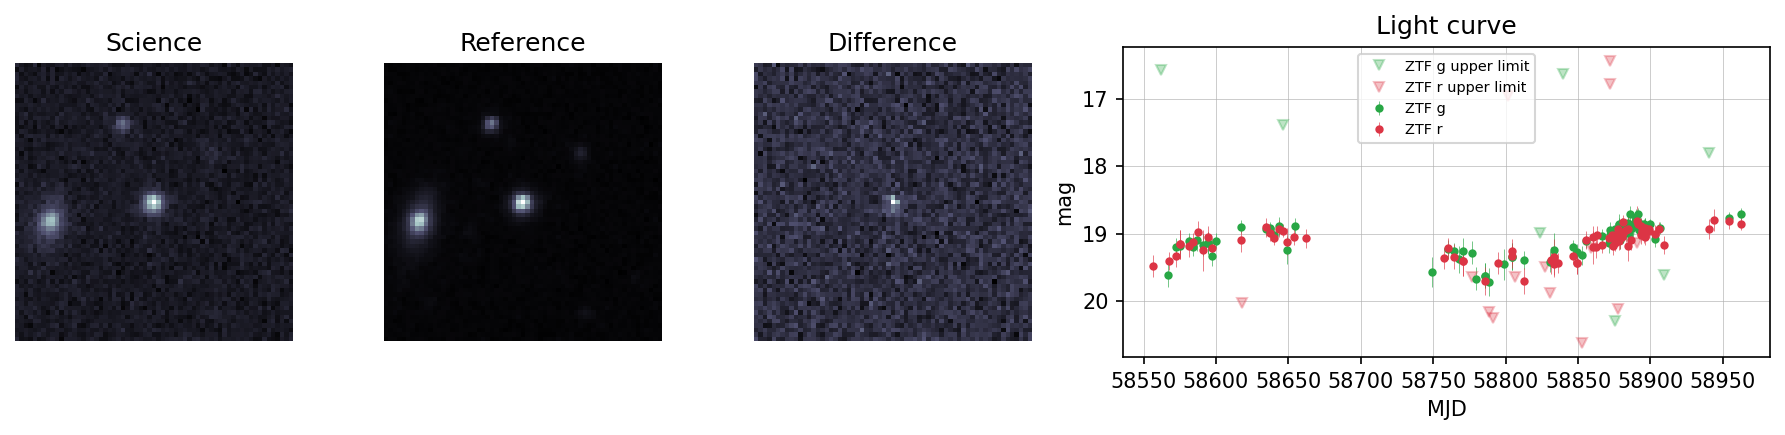

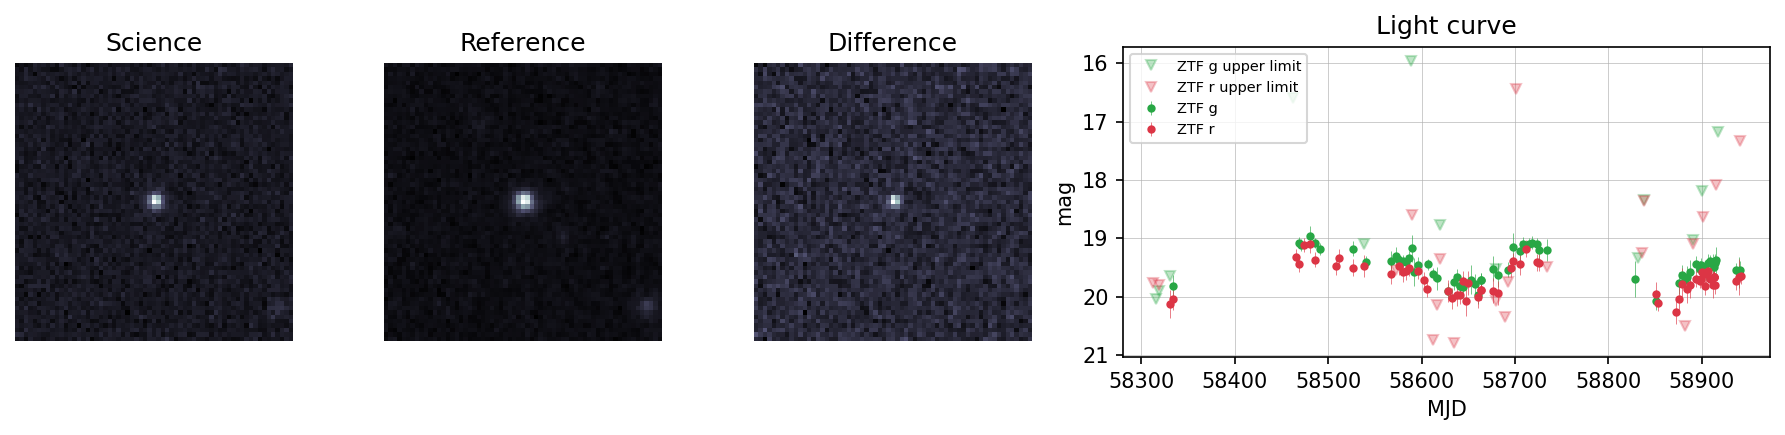

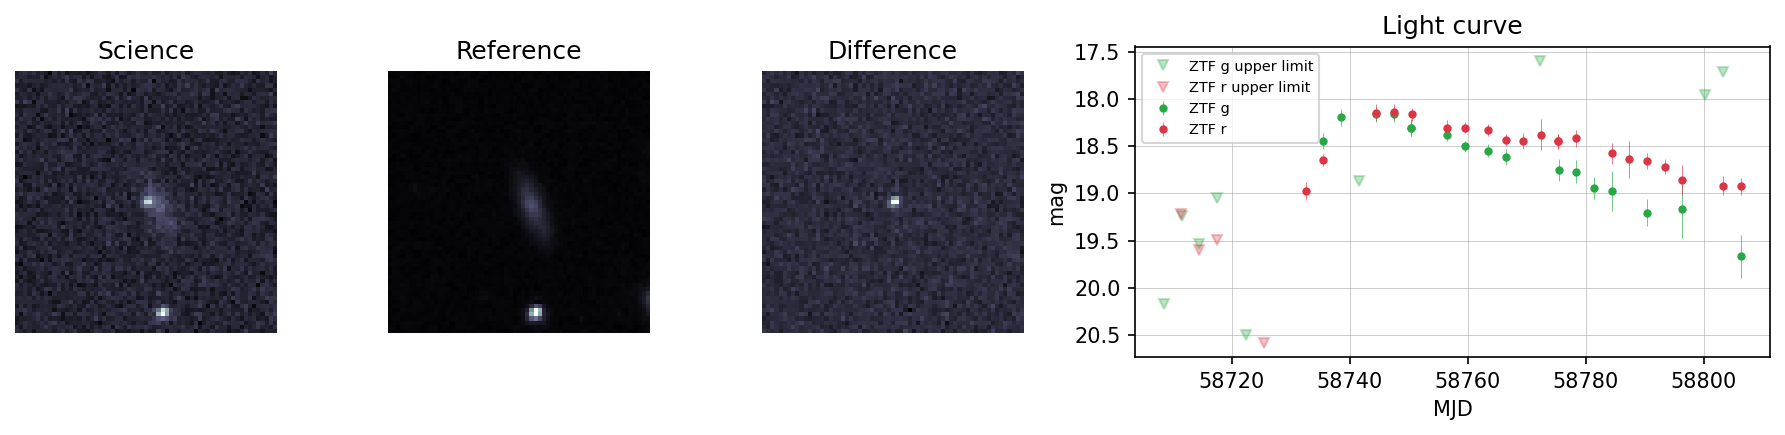

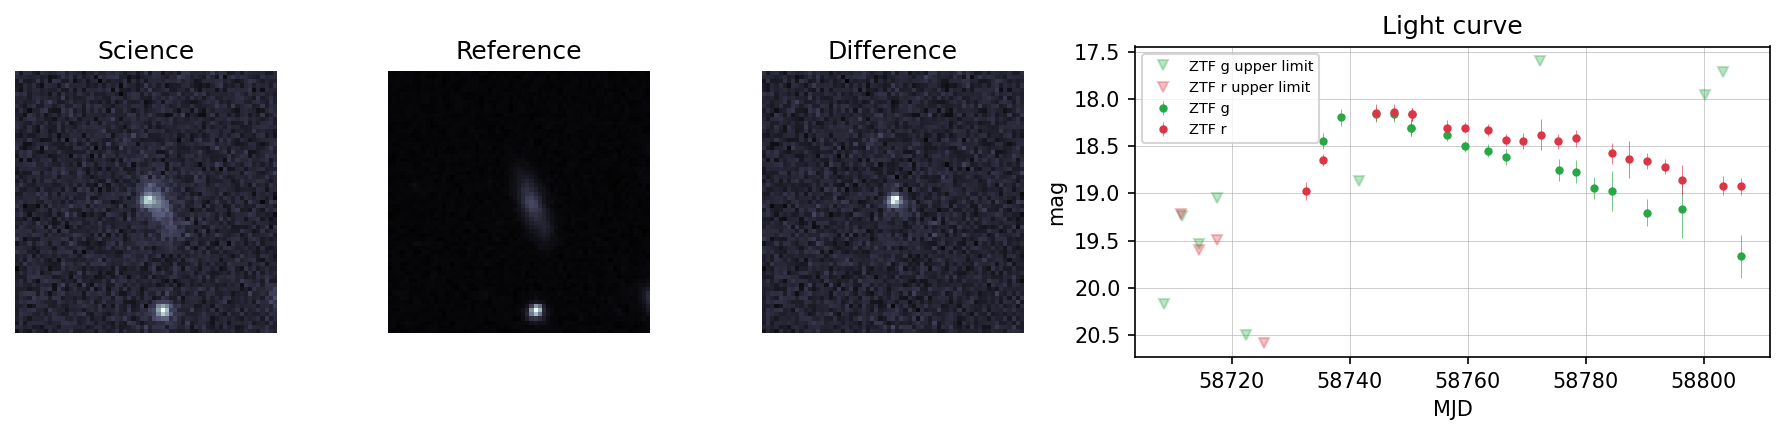

/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


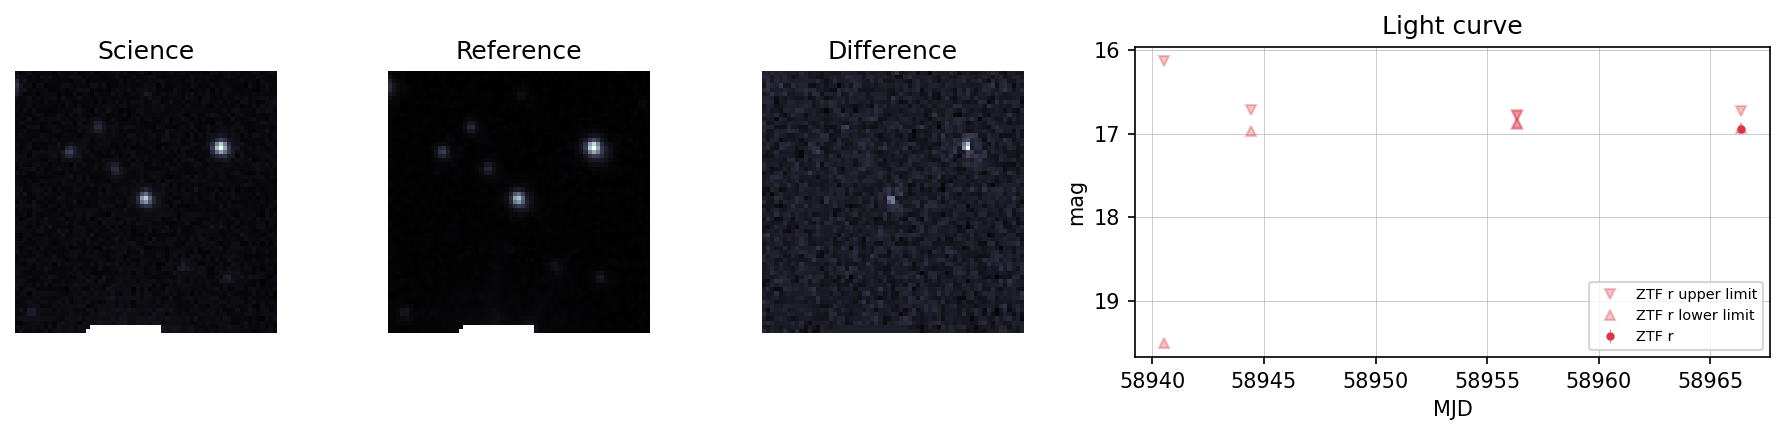

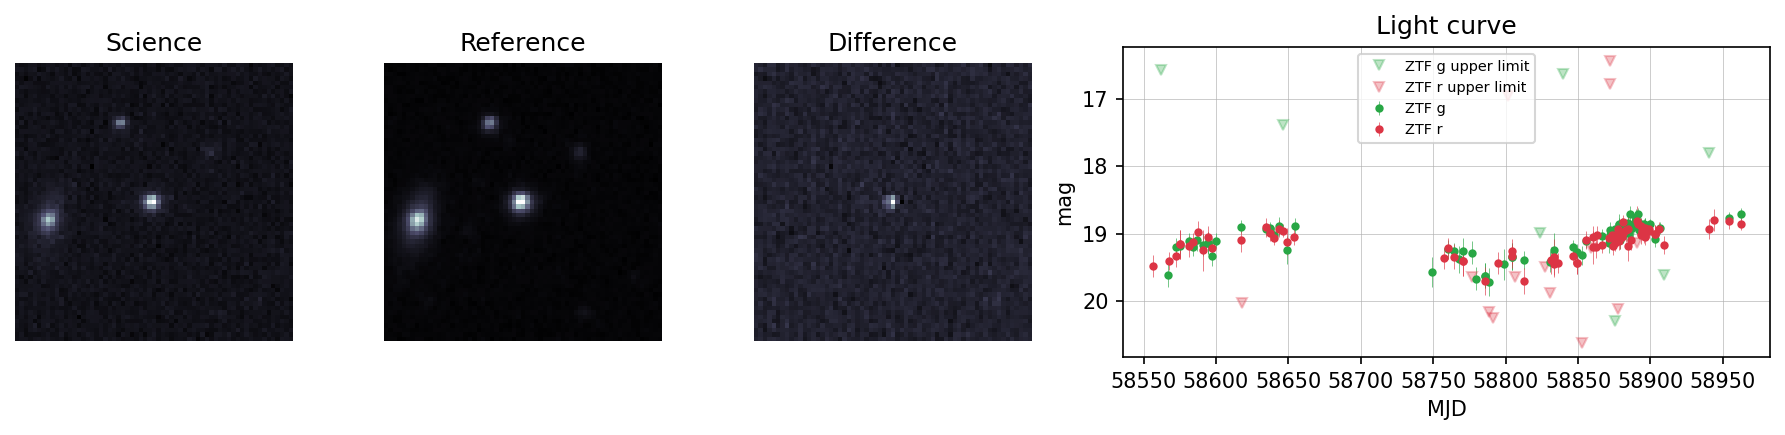

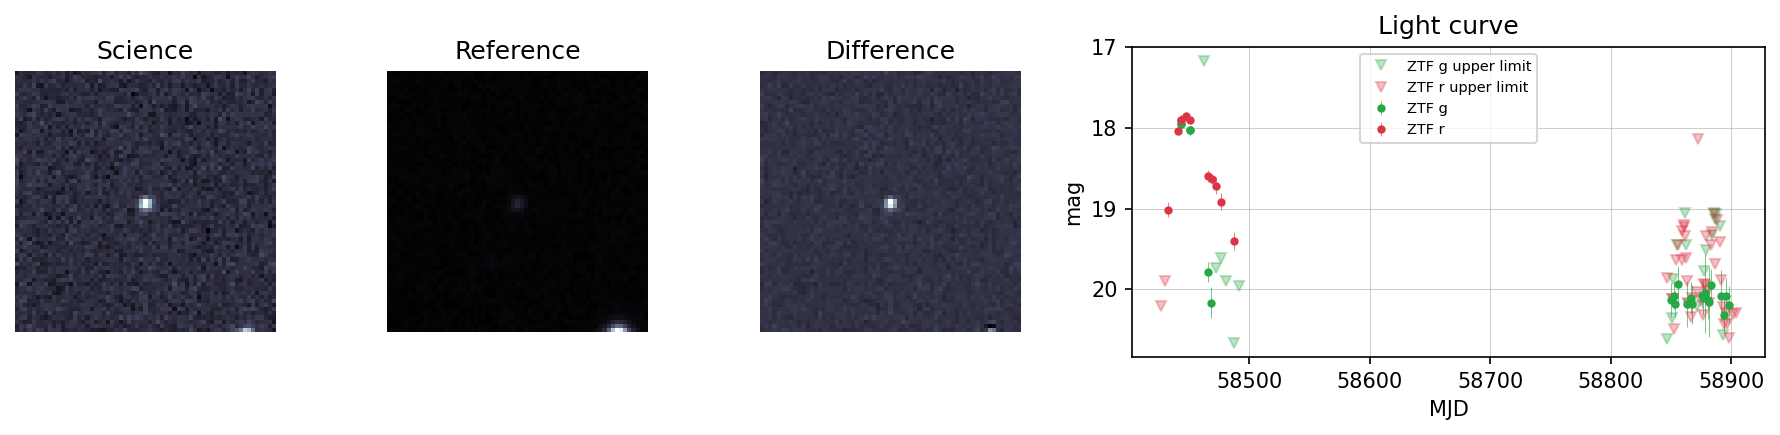

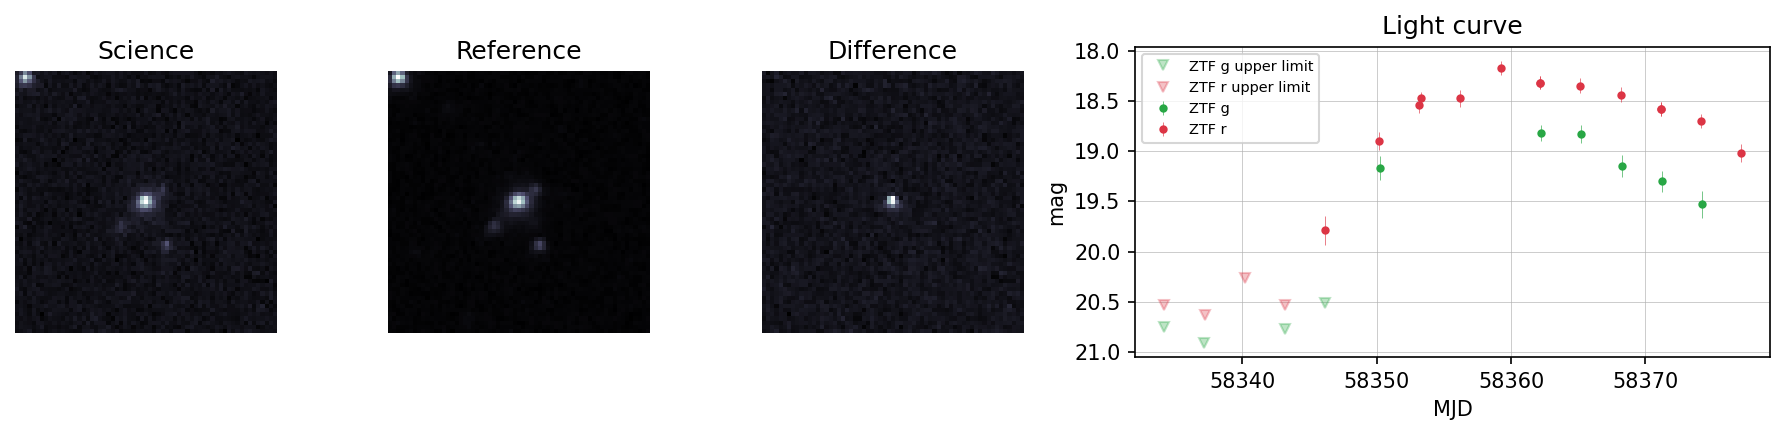

/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/mcoughlin/opt/anaconda3/envs/ast8581/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


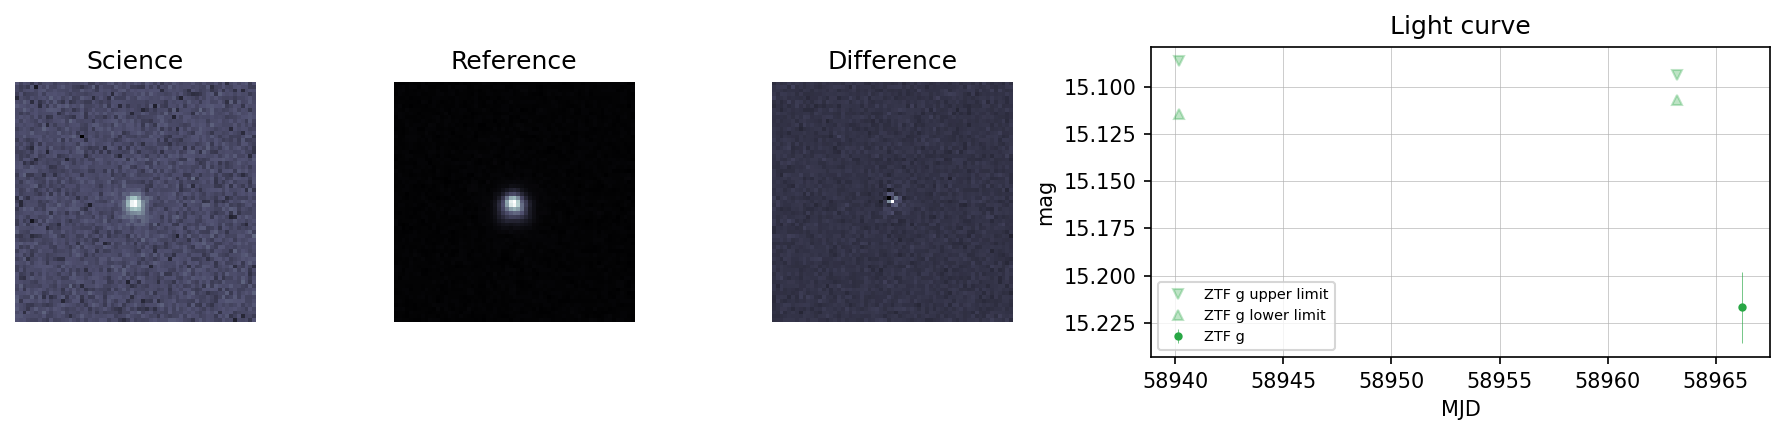

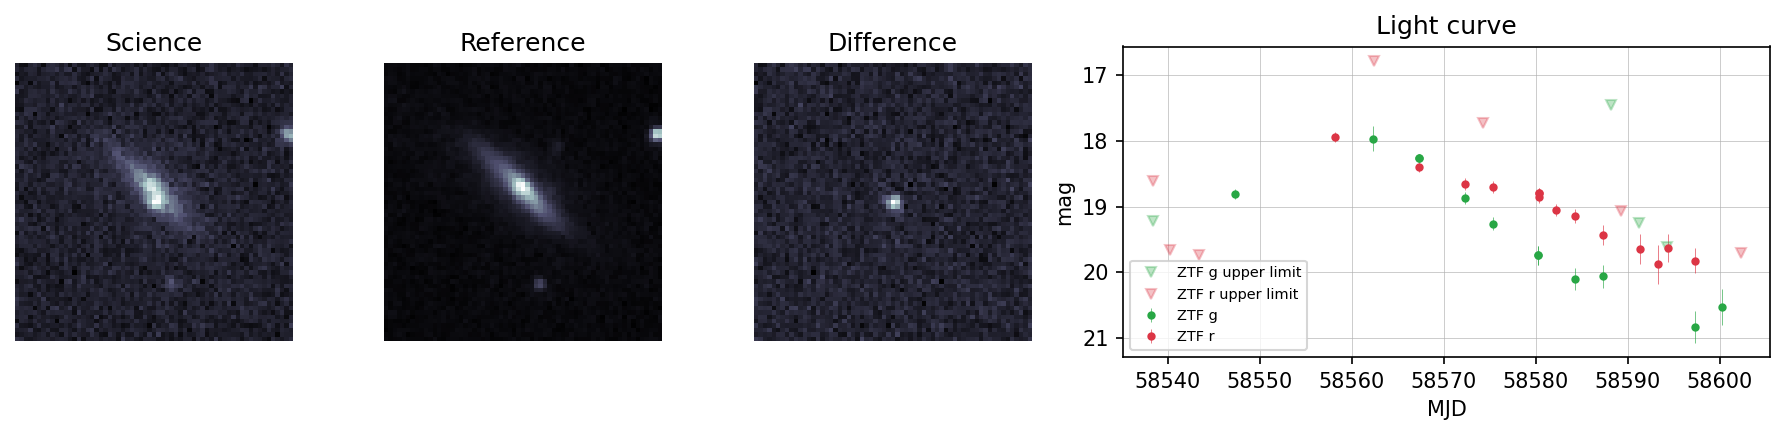

In [24]:
for alert in cursor:
    display_alert_triplet_lc(alert)

### Positional queries

The `coordinates.radec_geojson` field defined for every object in our `ZTF_alerts` collection has an associated spherical 2D index, which allows for efficient positional queries. `MongoDB` supports many query operators, see [here](https://docs.mongodb.com/manual/reference/operator/query-geospatial/) for more details. The caveat to keep in mind is the following: `MongoDB` uses `GeoJSON` objects to represent `2D` positions on the sphere. Both the longitude (`R.A.`) and latitude (`Decl.`) must be expressed in decimal degrees, and the valid longitude values are between `-180` and `180`, both inclusive, so you must subtract 180.0 degrees from your `R.A.` value.

Let's define a helper function for cone searches:

In [25]:
def cone_search(_db, collection='ZTF_alerts',
                ra=0.0, dec=0.0, radius=1.0, unit='arcsec',
                projection=None):
    # cone search radius:
    cone_search_radius = float(radius)
    # convert to rad:
    if unit == 'arcsec':
        cone_search_radius *= np.pi / 180.0 / 3600.
    elif unit == 'arcmin':
        cone_search_radius *= np.pi / 180.0 / 60.
    elif unit == 'deg':
        cone_search_radius *= np.pi / 180.0
    elif unit == 'rad':
        cone_search_radius *= 1
    else:
        raise Exception('Unknown cone search unit. Must be in [deg, rad, arcsec, arcmin]')
    
    # fields to return: everything by default
    if projection is None:
        projection = dict()
    
    cursor = _db[collection].find({}, projection)
    
    cursor = db['ZTF_alerts'].aggregate([
        {
            "$match": {
                'coordinates.radec_geojson': {
                    '$geoWithin': {
                        '$centerSphere': [[ra - 180.0, dec], cone_search_radius]
                    }
                }
            }
        },
        {
            "$lookup": {
                "from": "ZTF_alerts_aux",
                "localField": "objectId",
                "foreignField": "_id",
                "as": "aux"
            }
        },
        {
            "$replaceRoot": {
                "newRoot": {
                    "$mergeObjects": [
                        {
                            "$arrayElemAt": [
                                "$aux",
                                0
                            ]
                        },
                        "$$ROOT"
                    ]
                }
            }
        }
    ])
    
    return cursor

Now let us look for some transients in <a href="https://en.wikipedia.org/wiki/Messier_100" target="_blank">Messier 100</a>:

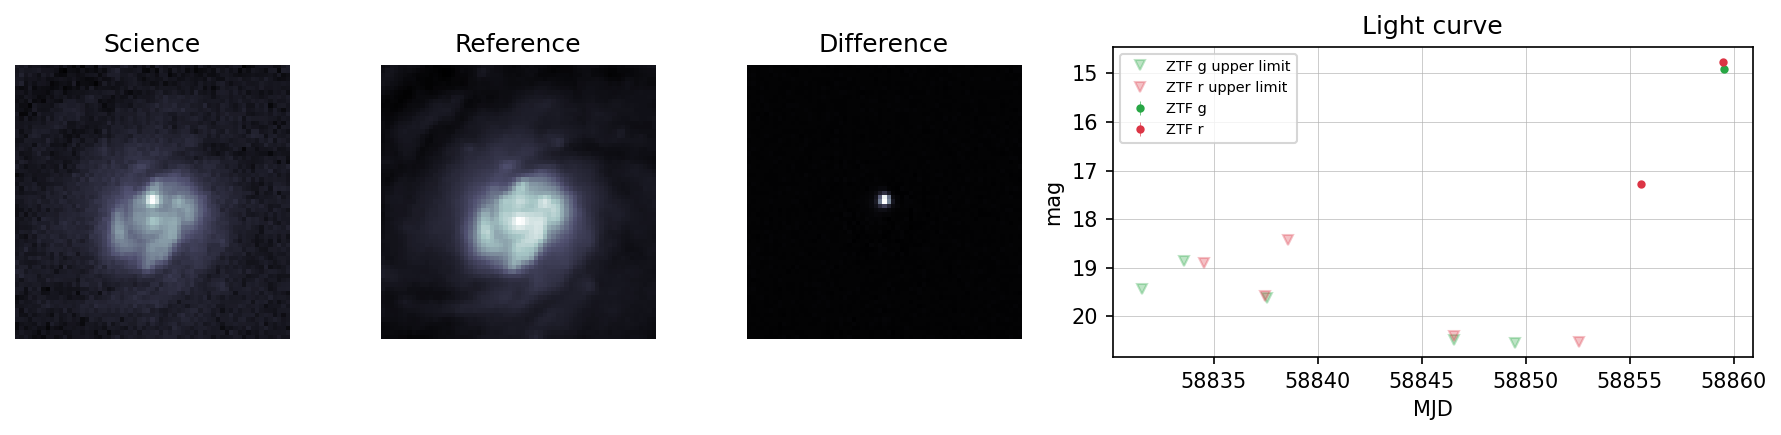

In [26]:
alerts = list(
    cone_search(db, ra=185.7287500, dec=15.8225000, radius=30.0, unit='arcsec', projection={'_id': 0})
)

for alert in alerts:
    display_alert_triplet_lc(alert)

## Further studying

<a href="https://www.coursera.org/learn/introduction-mongodb" target="_blank">Introduction to MongoDB official class <i class="fa fa-external-link" aria-hidden="true"></i></a>

<a href="https://www.datacamp.com/community/tutorials/introduction-mongodb-python" target="_blank">Introduction to MongoDB and Python <i class="fa fa-external-link" aria-hidden="true"></i></a>

<a href="https://docs.mongodb.com/manual/reference/sql-aggregation-comparison/" target="_blank">SQL to MongoDB Aggregation Mapping Chart <i class="fa fa-external-link" aria-hidden="true"></i></a>